## Importing libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import plotly.figure_factory as ff
from plotly.offline import iplot
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score, plot_confusion_matrix
import scikitplot as skplt
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
sns.set(style = 'whitegrid')

## Loading dataset

In [3]:
df = pd.read_csv('./Data/WA_Fn-UseC_-HR-Employee-Attrition.csv')

In [4]:
df.head()

Age Attrition     BusinessTravel  DailyRate              Department  \
0   41       Yes      Travel_Rarely       1102                   Sales   
1   49        No  Travel_Frequently        279  Research & Development   
2   37       Yes      Travel_Rarely       1373  Research & Development   
3   33        No  Travel_Frequently       1392  Research & Development   
4   27        No      Travel_Rarely        591  Research & Development   

   DistanceFromHome  Education EducationField  EmployeeCount  EmployeeNumber  \
0                 1          2  Life Sciences              1               1   
1                 8          1  Life Sciences              1               2   
2                 2          2          Other              1               4   
3                 3          4  Life Sciences              1               5   
4                 2          1        Medical              1               7   

   ...  RelationshipSatisfaction StandardHours  StockOptionLevel  \
0  ...                         1            80                 0   
1  ...                         4            80                 1   
2  ...                         2            80                 0   
3  ...                         3            80                 0   
4  ...                         4            80                 1   

   TotalWorkingYears  TrainingTimesLastYear WorkLifeBalance  YearsAtCompany  \
0                  8                      0               1               6   
1                 10                      3               3              10   
2                  7                      3               3               0   
3                  8                      3               3               8   
4                  6                      3               3               2   

  YearsInCurrentRole  YearsSinceLastPromotion  YearsWithCurrManager  
0                  4                        0                     5  
1                  7                        1                     7  
2                  0                        0                     0  
3                  7                        3                     0  
4                  2                        2                     2  

[5 rows x 35 columns]

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

## EDA

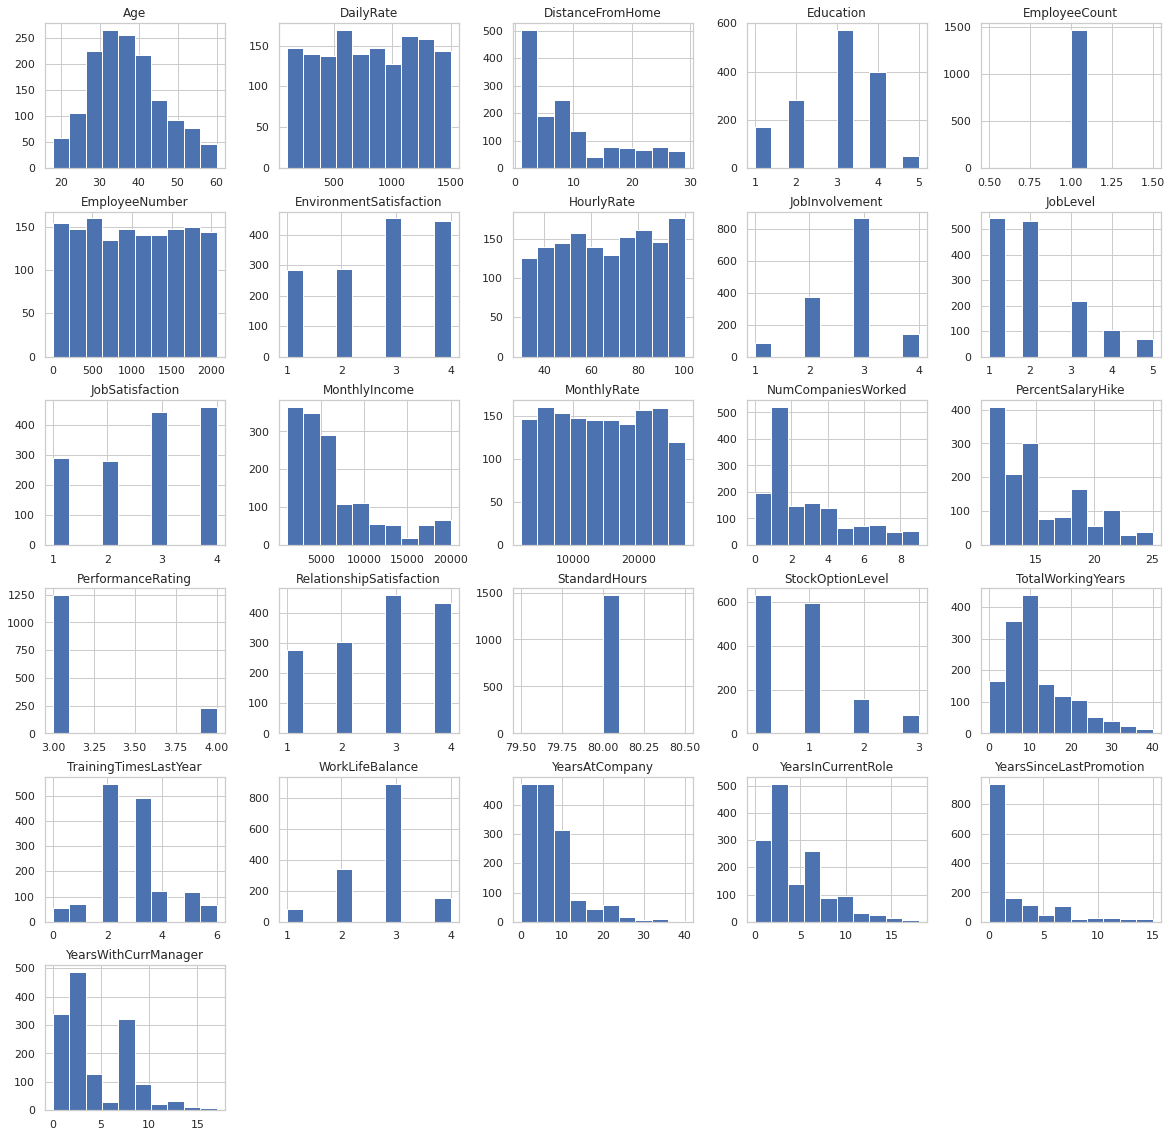

In [6]:
sns.set(style = 'whitegrid')
df.hist(figsize = (20, 20))
plt.show()

## Feature distribution by target variable

### Age

In [7]:
(mu_yes, sigma_yes) = norm.fit(df.loc[df.Attrition == 'Yes', 'Age'])

In [8]:
print(mu_yes, sigma_yes)

33.607594936708864 9.668886620354689


In [9]:
(mu_no, sigma_no) = norm.fit(df.loc[df.Attrition == 'No', 'Age'])

In [10]:
print(mu_no, sigma_no)

37.561232765612324 8.884754930516747


In [11]:
x1 = df.loc[df.Attrition == 'No', 'Age']
x2 = df.loc[df.Attrition == 'Yes', 'Age']

In [12]:
hist_data = [x1, x2]
group_labels = ['active_employees', 'ex_employees']

In [13]:
fig = ff.create_distplot(hist_data, group_labels, curve_type = 'kde', show_hist = False, show_rug = False)

In [14]:
fig['layout'].update(title = 'Age Distribution in percent by Attrition Status')
fig['layout'].update(xaxis = dict(range = [15, 60], dtick = 5))
fig.show()

<AxesSubplot:xlabel='Age'>

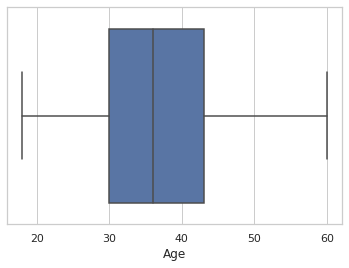

In [15]:
sns.boxplot(x = df.Age)

- No outliers

### Education Field

In [16]:
df.EducationField.value_counts()

Life Sciences       606
Medical             464
Marketing           159
Technical Degree    132
Other                82
Human Resources      27
Name: EducationField, dtype: int64

<AxesSubplot:title={'center':'Leavers by Education Field (%)'}, xlabel='Field'>

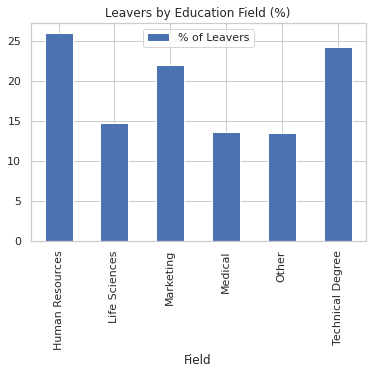

In [17]:
df_education_field = pd.DataFrame(columns = ['Field', '% of Leavers'])
for i, field in enumerate(list(df.EducationField.unique())):
    ratio = df[(df.EducationField == field) & (df.Attrition == 'Yes')].shape[0] / df[df.EducationField == field].shape[0]
    df_education_field.loc[i] = (field, ratio * 100)
df_EF = df_education_field.groupby(by = 'Field').sum()
df_EF.plot(kind = 'bar', title = 'Leavers by Education Field (%)')

### Gender

In [18]:
df.Gender.value_counts()

Male      882
Female    588
Name: Gender, dtype: int64

In [19]:
print('Gender distribution of ex-employees in the dataset: Male = {:.1f}%: Female = {:.1f}%'.format((df[(df.Gender == 'Male') & (df.Attrition == 'Yes')].shape[0] / 
      df[df.Gender == 'Male'].shape[0]) * 100, (df[(df.Gender == 'Female') & (df.Attrition == 'Yes')].shape[0] / 
      df[df.Gender == 'Female'].shape[0]) * 100))

Gender distribution of ex-employees in the dataset: Male = 17.0%: Female = 14.8%


<AxesSubplot:title={'center':'Leavers by Gender (%)'}, xlabel='gender'>

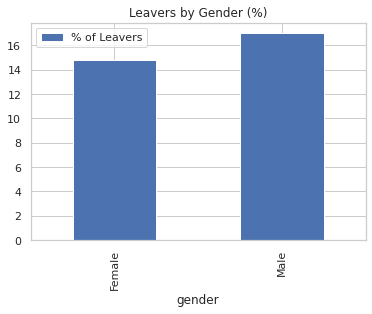

In [20]:
df_gender = pd.DataFrame(columns = ['gender', '% of Leavers'])
for i, gender in enumerate(list(df.Gender.unique())):
    ratio = df[(df.Gender == gender) & (df.Attrition == 'Yes')].shape[0] / df[df.Gender == gender].shape[0]
    df_gender.loc[i] = (gender, ratio * 100)
df_G = df_gender.groupby(by = 'gender').sum()
df_G.plot(kind = 'bar', title = 'Leavers by Gender (%)')

### Marital Status

In [21]:
df.MaritalStatus.value_counts()

Married     673
Single      470
Divorced    327
Name: MaritalStatus, dtype: int64

<AxesSubplot:title={'center':'Leavers by marital status (%)'}, xlabel='marital_status'>

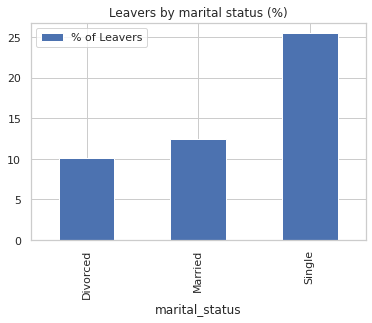

In [22]:
df_marital = pd.DataFrame(columns = ['marital_status', '% of Leavers'])
for i, marital in enumerate(list(df.MaritalStatus.unique())):
    ratio = df[(df.MaritalStatus == marital) & (df.Attrition == 'Yes')].shape[0] / df[df.MaritalStatus == marital].shape[0]
    df_marital.loc[i] = (marital, ratio * 100)
df_MS = df_marital.groupby(by = 'marital_status').sum()
df_MS.plot(kind = 'bar', title = 'Leavers by marital status (%)')

### Distance from home

In [23]:
print("Distance from home for employees to get to work is from {} to {} miles.".format(df.DistanceFromHome.min(), df.DistanceFromHome.max()))

Distance from home for employees to get to work is from 1 to 29 miles.


In [24]:
print('Average distance from home for: Current employees = {:.2f}: Ex-employees = {:.2f}'.format((df[df.Attrition == 'No'].DistanceFromHome.mean()), 
                                                                                                 (df[df.Attrition == 'Yes'].DistanceFromHome.mean())))

Average distance from home for: Current employees = 8.92: Ex-employees = 10.63


In [25]:
x1 = df.loc[df.Attrition == 'No', 'DistanceFromHome']
x2 = df.loc[df.Attrition == 'Yes', 'DistanceFromHome']
hist = [x1, x2]
group_labels = ['Active Employees', 'Ex-Employees']

In [26]:
fig = ff.create_distplot(hist, group_labels, curve_type = 'kde', show_hist = False, show_rug = False)
fig['layout'].update(title = 'Distance from home dist. by attribution status')
fig['layout'].update(xaxis = dict(range = [0, 30], dtick = 2))
fig.show()

<AxesSubplot:xlabel='DistanceFromHome'>

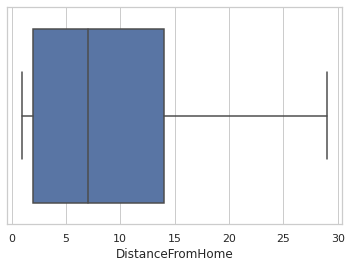

In [27]:
sns.boxplot(x = df.DistanceFromHome)

### Department

In [28]:
df.Department.value_counts()

Research & Development    961
Sales                     446
Human Resources            63
Name: Department, dtype: int64

<AxesSubplot:title={'center':'Leavers by department (%)'}, xlabel='department'>

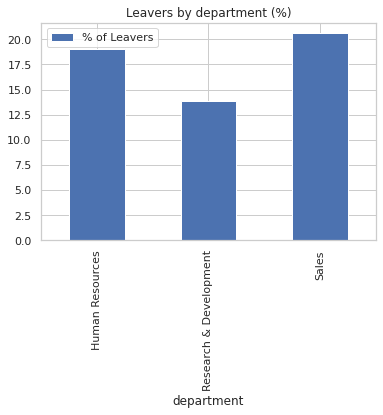

In [29]:
df_department = pd.DataFrame(columns = ['department', '% of Leavers'])
for i, department in enumerate(list(df.Department.unique())):
    ratio = df[(df.Department == department) & (df.Attrition == 'Yes')].shape[0] / df[df.Department == department].shape[0]
    df_department.loc[i] = (department, ratio * 100)
df_D = df_department.groupby(by = 'department').sum()
df_D.plot(kind = 'bar', title = 'Leavers by department (%)')

### Travel frequency

In [30]:
df.BusinessTravel.value_counts()

Travel_Rarely        1043
Travel_Frequently     277
Non-Travel            150
Name: BusinessTravel, dtype: int64

<AxesSubplot:title={'center':'Leavers by their frequency of travel (%)'}, xlabel='business_travel'>

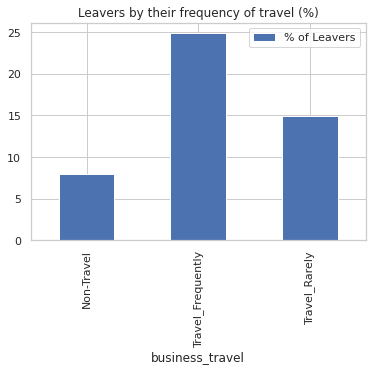

In [31]:
df_business_travel = pd.DataFrame(columns = ['business_travel', '% of Leavers'])
for i, travel in enumerate(list(df.BusinessTravel.unique())):
    ratio = df[(df.BusinessTravel == travel) & (df.Attrition == 'Yes')].shape[0] / df[df.BusinessTravel == travel].shape[0]
    df_business_travel.loc[i] = (travel, ratio * 100)
df_BT = df_business_travel.groupby(by = 'business_travel').sum()
df_BT.plot(kind = 'bar', title = 'Leavers by their frequency of travel (%)')

### Job role

In [32]:
df.JobRole.value_counts()

Sales Executive              326
Research Scientist           292
Laboratory Technician        259
Manufacturing Director       145
Healthcare Representative    131
Manager                      102
Sales Representative          83
Research Director             80
Human Resources               52
Name: JobRole, dtype: int64

<AxesSubplot:title={'center':'Leavers by job role (%)'}, xlabel='job_role'>

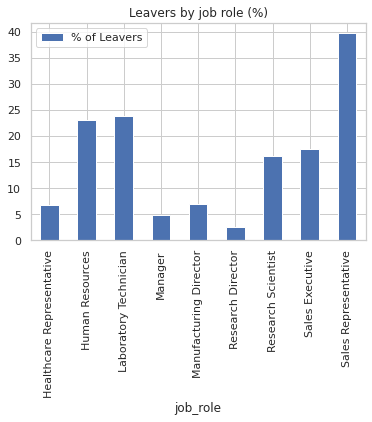

In [33]:
df_job_role = pd.DataFrame(columns = ['job_role', '% of Leavers'])
for i, job_role in enumerate(list(df.JobRole.unique())):
    ratio = df[(df.JobRole == job_role) & (df.Attrition == 'Yes')].shape[0] / df[df.JobRole == job_role].shape[0]
    df_job_role.loc[i] = (job_role, ratio * 100)
df_JR = df_job_role.groupby(by = 'job_role').sum()
df_JR.plot(kind = 'bar', title = 'Leavers by job role (%)')

### Job level

In [34]:
df.JobLevel.value_counts()

1    543
2    534
3    218
4    106
5     69
Name: JobLevel, dtype: int64

<AxesSubplot:title={'center':'Leavers by job level (%)'}, xlabel='job_level'>

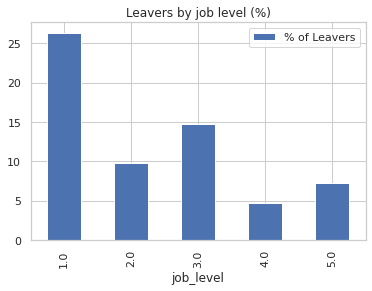

In [35]:
df_job_level = pd.DataFrame(columns = ['job_level', '% of Leavers'])
for i, job_level in enumerate(list(df.JobLevel.unique())):
    ratio = df[(df.JobLevel == job_level) & (df.Attrition == 'Yes')].shape[0] / df[df.JobLevel == job_level].shape[0]
    df_job_level.loc[i] = (job_level, ratio * 100)
df_JL = df_job_level.groupby(by = 'job_level').sum()
df_JL.plot(kind = 'bar', title = 'Leavers by job level (%)')

### Job involvement

In [36]:
df.JobInvolvement.value_counts()

3    868
2    375
4    144
1     83
Name: JobInvolvement, dtype: int64

<AxesSubplot:title={'center':'Leavers by job involvement (%)'}, xlabel='job_involvement'>

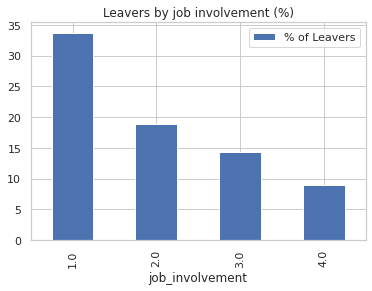

In [37]:
df_job_involvement = pd.DataFrame(columns = ['job_involvement', '% of Leavers'])
for i, job_involvement in enumerate(list(df.JobInvolvement.unique())):
    ratio = df[(df.JobInvolvement == job_involvement) & (df.Attrition == 'Yes')].shape[0] / df[df.JobInvolvement == job_involvement].shape[0]
    df_job_involvement.loc[i] = (job_involvement, ratio * 100)
df_JI = df_job_involvement.groupby(by = 'job_involvement').sum()
df_JI.plot(kind = 'bar', title = 'Leavers by job involvement (%)')

### Training time

In [38]:
df.TrainingTimesLastYear.value_counts()

2    547
3    491
4    123
5    119
1     71
6     65
0     54
Name: TrainingTimesLastYear, dtype: int64

<AxesSubplot:title={'center':'Leavers by job involvement (%)'}, xlabel='training'>

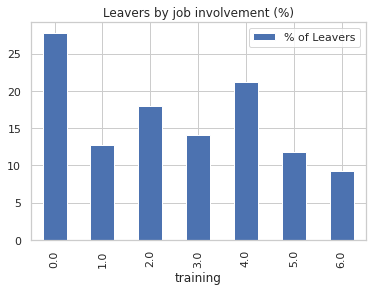

In [39]:
df_training = pd.DataFrame(columns = ['training', '% of Leavers'])
for i, training in enumerate(list(df.TrainingTimesLastYear.unique())):
    ratio = df[(df.TrainingTimesLastYear == training) & (df.Attrition == 'Yes')].shape[0] / df[df.TrainingTimesLastYear == training].shape[0]
    df_training.loc[i] = (training, ratio * 100)
df_T = df_training.groupby(by = 'training').sum()
df_T.plot(kind = 'bar', title = 'Leavers by job involvement (%)')

### Number of Companies worked

In [40]:
df.NumCompaniesWorked.value_counts()

1    521
0    197
3    159
2    146
4    139
7     74
6     70
5     63
9     52
8     49
Name: NumCompaniesWorked, dtype: int64

<AxesSubplot:title={'center':'Leavers by number of companies worked (%)'}, xlabel='companies_worked'>

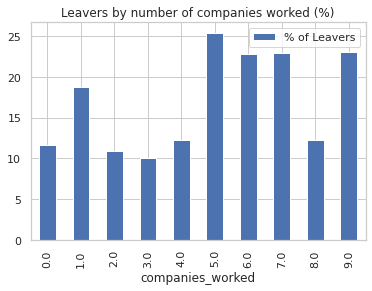

In [41]:
df_companies_worked = pd.DataFrame(columns = ['companies_worked', '% of Leavers'])
for i, companies in enumerate(list(df.NumCompaniesWorked.unique())):
    ratio = df[(df.NumCompaniesWorked == companies) & (df.Attrition == 'Yes')].shape[0] / df[df.NumCompaniesWorked == companies].shape[0]
    df_companies_worked.loc[i] = (companies, ratio * 100)
df_CW = df_companies_worked.groupby(by = 'companies_worked').sum()
df_CW.plot(kind = 'bar', title = 'Leavers by number of companies worked (%)')

### Years at the company

In [42]:
print('Average no. of years at the company for: Current employees = {:.2f}; Ex-employees = {:.2f}'.format((df[df.Attrition == 'No'].YearsAtCompany.mean()), 
                                                                                                          (df[df.Attrition == 'Yes'].YearsAtCompany.mean())))

Average no. of years at the company for: Current employees = 7.37; Ex-employees = 5.13


In [43]:
print(df.YearsAtCompany.min(), df.YearsAtCompany.max())

0 40


In [44]:
x1 = df.loc[df.Attrition == 'No', 'YearsAtCompany']
x2 = df.loc[df.Attrition == 'Yes', 'YearsAtCompany']
hist_data = [x1, x2]
group_labels = ['Active employees', 'Ex-employees']
fig = ff.create_distplot(hist_data, group_labels, curve_type = 'kde', show_hist = False, show_rug = False)
fig['layout'].update(title = 'Years at company in percent by attrition status')
fig['layout'].update(xaxis = dict(range = [0, 40], dtick = 5))
fig.show()

<AxesSubplot:xlabel='YearsAtCompany'>

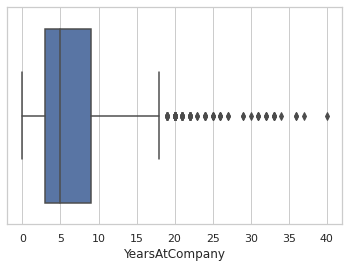

In [45]:
sns.boxplot(x = df.YearsAtCompany)

- Seems like the feature has outliers but there might be cases in which the employee works in the company for 40 years.

### No. of years in current role

In [46]:
df.YearsInCurrentRole.nunique()

19

In [47]:
print('Min : {}, Max : {}'.format(df.YearsInCurrentRole.min(), df.YearsInCurrentRole.max()))

Min : 0, Max : 18


In [48]:
x1 = df.loc[df.Attrition == 'No', 'YearsInCurrentRole']
x2 = df.loc[df.Attrition == 'Yes', 'YearsInCurrentRole']
hist_data = [x1, x2]
group_labels = ['Active employees', 'Ex-employees']
fig = ff.create_distplot(hist_data, group_labels, curve_type = 'kde', show_hist = False, show_rug = False)
fig['layout'].update(title = 'Years in current role in percent by attrition status')
fig['layout'].update(xaxis = dict(range = [0, 40], dtick = 5))
fig.show()

<AxesSubplot:xlabel='YearsInCurrentRole'>

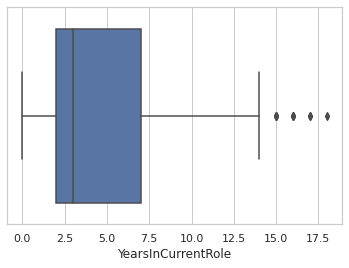

In [49]:
sns.boxplot(x = df.YearsInCurrentRole)

<AxesSubplot:xlabel='YearsInCurrentRole', ylabel='JobLevel'>

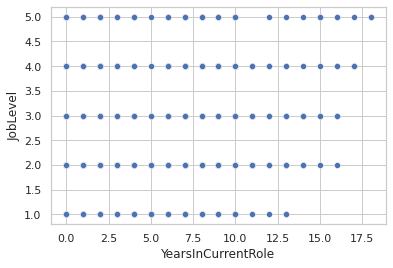

In [50]:
sns.scatterplot(x = df.YearsInCurrentRole, y = df.JobLevel)

- Since the people working for 15 years or greater in the same role are having a much higher job role than others, they cannot be considered as outliers.

### Total working years

In [51]:
df.TotalWorkingYears.nunique()

40

In [52]:
print('Min : {}, Max : {}'.format(df.TotalWorkingYears.min(), df.TotalWorkingYears.max()))

Min : 0, Max : 40


In [53]:
x1 = df.loc[df.Attrition == 'No', 'TotalWorkingYears']
x2 = df.loc[df.Attrition == 'Yes', 'TotalWorkingYears']
hist_data = [x1, x2]
group_labels = ['Active employees', 'Ex-employees']
fig = ff.create_distplot(hist_data, group_labels, curve_type = 'kde', show_hist = False, show_rug = False)
fig['layout'].update(title = 'Total working years in percent by attrition status')
fig['layout'].update(xaxis = dict(range = [0, 40], dtick = 5))
fig.show()

<AxesSubplot:xlabel='TotalWorkingYears'>

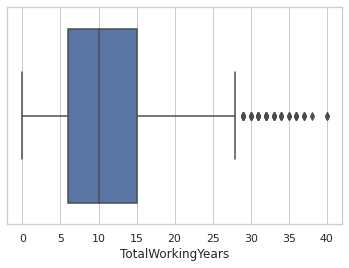

In [54]:
sns.boxplot(x = df.TotalWorkingYears)

### Years with current manager

In [55]:
df.YearsWithCurrManager.nunique()

18

In [56]:
print('Min : {}, Max : {}'.format(df.YearsWithCurrManager.min(), df.YearsWithCurrManager.max()))

Min : 0, Max : 17


In [57]:
x1 = df.loc[df.Attrition == 'No', 'YearsWithCurrManager']
x2 = df.loc[df.Attrition == 'Yes', 'YearsWithCurrManager']
hist_data = [x1, x2]
group_labels = ['Active employees', 'Ex-employees']
fig = ff.create_distplot(hist_data, group_labels, curve_type = 'kde', show_hist = False, show_rug = False)
fig['layout'].update(title = 'Years with current manager in percent by attrition status')
fig['layout'].update(xaxis = dict(range = [0, 40], dtick = 5))
fig.show()

<AxesSubplot:xlabel='YearsWithCurrManager'>

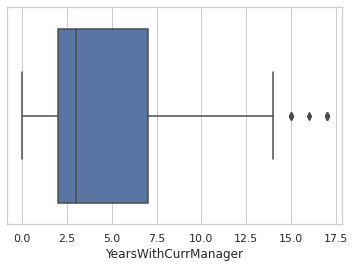

In [58]:
sns.boxplot(x = df.YearsWithCurrManager)

### Work-life balance score

In [59]:
df.WorkLifeBalance.value_counts()

3    893
2    344
4    153
1     80
Name: WorkLifeBalance, dtype: int64

<AxesSubplot:title={'center':'Leavers by worklife balance (%)'}, xlabel='worklife_balance'>

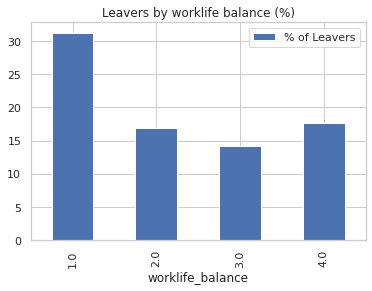

In [60]:
df_worklife_balance = pd.DataFrame(columns = ['worklife_balance', '% of Leavers'])
for i, worklife in enumerate(list(df.WorkLifeBalance.unique())):
    ratio = df[(df.WorkLifeBalance == worklife) & (df.Attrition == 'Yes')].shape[0] / df[df.WorkLifeBalance == worklife].shape[0]
    df_worklife_balance.loc[i] = (worklife, ratio * 100)
df_WLB = df_worklife_balance.groupby(by = 'worklife_balance').sum()
df_WLB.plot(kind = 'bar', title = 'Leavers by worklife balance (%)')

### Overtime

In [61]:
df.OverTime.value_counts()

No     1054
Yes     416
Name: OverTime, dtype: int64

<AxesSubplot:title={'center':'Leavers by overtime (%)'}, xlabel='overtime'>

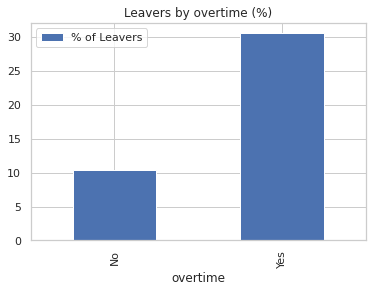

In [62]:
df_overtime = pd.DataFrame(columns = ['overtime', '% of Leavers'])
for i, overtime in enumerate(list(df.OverTime.unique())):
    ratio = df[(df.OverTime == overtime) & (df.Attrition == 'Yes')].shape[0] / df[df.OverTime == overtime].shape[0]
    df_overtime.loc[i] = (overtime, ratio * 100)
df_OT = df_overtime.groupby(by = 'overtime').sum()
df_OT.plot(kind = 'bar', title = 'Leavers by overtime (%)')

### Hourly rate

In [63]:
df.HourlyRate.nunique()

71

In [64]:
print('Min : {}, Max : {}'.format(df.HourlyRate.min(), df.HourlyRate.max()))

Min : 30, Max : 100


In [65]:
x1 = df.loc[df.Attrition == 'No', 'HourlyRate']
x2 = df.loc[df.Attrition == 'Yes', 'HourlyRate']
hist_data = [x1, x2]
group_labels = ['Active employees', 'Ex-employees']
fig = ff.create_distplot(hist_data, group_labels, curve_type = 'kde', show_hist = False, show_rug = False)
fig['layout'].update(title = 'Hourly rate of employees in percent by attrition status')
fig['layout'].update(xaxis = dict(range = [30, 100], dtick = 5))
fig.show()

<AxesSubplot:xlabel='HourlyRate'>

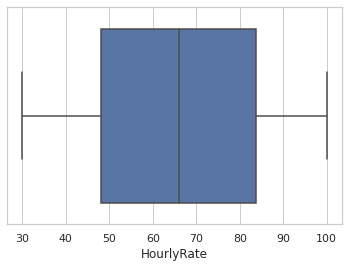

In [66]:
sns.boxplot(x = df.HourlyRate)

### Daily rate

In [67]:
df.DailyRate.nunique()

886

In [68]:
print('Min : {}, Max : {}'.format(df.DailyRate.min(), df.DailyRate.max()))

Min : 102, Max : 1499


In [69]:
x1 = df.loc[df.Attrition == 'No', 'DailyRate']
x2 = df.loc[df.Attrition == 'Yes', 'DailyRate']
hist_data = [x1, x2]
group_labels = ['Active employees', 'Ex-employees']
fig = ff.create_distplot(hist_data, group_labels, curve_type = 'kde', show_hist = False, show_rug = False)
fig['layout'].update(title = 'Daily rate of employees in percent by attrition status')
fig['layout'].update(xaxis = dict(range = [102, 1499], dtick = 100))
fig.show()

<AxesSubplot:xlabel='DailyRate'>

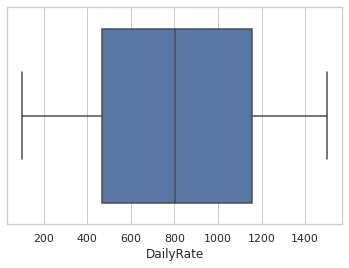

In [70]:
sns.boxplot(x = df.DailyRate)

### Monthly Rate

In [71]:
df.MonthlyRate.nunique()

1427

In [72]:
print('Min : {}, Max : {}'.format(df.MonthlyRate.min(), df.MonthlyRate.max()))

Min : 2094, Max : 26999


In [73]:
x1 = df.loc[df.Attrition == 'No', 'MonthlyRate']
x2 = df.loc[df.Attrition == 'Yes', 'MonthlyRate']
hist_data = [x1, x2]
group_labels = ['Active employees', 'Ex-employees']
fig = ff.create_distplot(hist_data, group_labels, curve_type = 'kde', show_hist = False, show_rug = False)
fig['layout'].update(title = 'Monthly rate of employees in percent by attrition status')
fig['layout'].update(xaxis = dict(range = [2094, 26999], dtick = 2000))
fig.show()

<AxesSubplot:xlabel='MonthlyRate'>

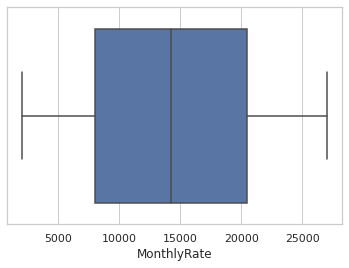

In [74]:
sns.boxplot(x = df.MonthlyRate)

### Monthly Income

In [75]:
df.MonthlyIncome.nunique()

1349

In [76]:
print('Min : {}, Max : {}'.format(df.MonthlyIncome.min(), df.MonthlyIncome.max()))

Min : 1009, Max : 19999


In [77]:
x1 = df.loc[df.Attrition == 'No', 'MonthlyIncome']
x2 = df.loc[df.Attrition == 'Yes', 'MonthlyIncome']
hist_data = [x1, x2]
group_labels = ['Active employees', 'Ex-employees']
fig = ff.create_distplot(hist_data, group_labels, curve_type = 'kde', show_hist = False, show_rug = False)
fig['layout'].update(title = 'Monthly income of employees in percent by attrition status')
fig['layout'].update(xaxis = dict(range = [1009, 20000], dtick = 2000))
fig.show()

<AxesSubplot:xlabel='MonthlyIncome'>

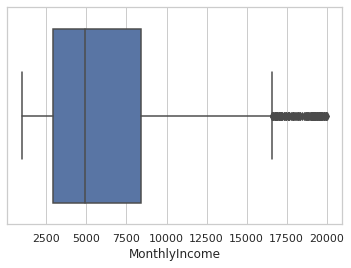

In [78]:
sns.boxplot(x = df.MonthlyIncome)

### Stock option

In [79]:
df.StockOptionLevel.nunique()

4

<AxesSubplot:title={'center':'Leavers by stock option level (%)'}, xlabel='stock_option_level'>

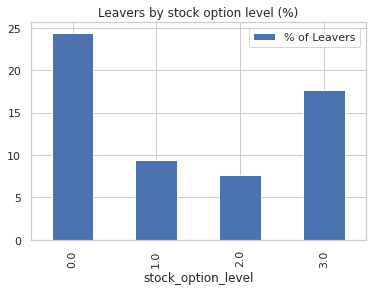

In [80]:
df_stock = pd.DataFrame(columns = ['stock_option_level', '% of Leavers'])
for i, stock in enumerate(list(df.StockOptionLevel.unique())):
    ratio = df[(df.StockOptionLevel == stock) & (df.Attrition == 'Yes')].shape[0] / df[df.StockOptionLevel == stock].shape[0]
    df_stock.loc[i] = (stock, ratio * 100)
df_SPL = df_stock.groupby(by = 'stock_option_level').sum()
df_SPL.plot(kind = 'bar', title = 'Leavers by stock option level (%)')

### Environment Satisfaction

In [81]:
df.EnvironmentSatisfaction.value_counts()

3    453
4    446
2    287
1    284
Name: EnvironmentSatisfaction, dtype: int64

<AxesSubplot:title={'center':'Leavers by environment satisfaction (%)'}, xlabel='environment_satisfaction'>

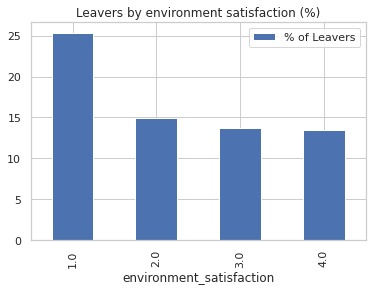

In [82]:
df_environment = pd.DataFrame(columns = ['environment_satisfaction', '% of Leavers'])
for i, environment in enumerate(list(df.EnvironmentSatisfaction.unique())):
    ratio = df[(df.EnvironmentSatisfaction == environment) & (df.Attrition == 'Yes')].shape[0] / df[df.EnvironmentSatisfaction == environment].shape[0]
    df_environment.loc[i] = (environment, ratio * 100)
df_ENV = df_environment.groupby(by = 'environment_satisfaction').sum()
df_ENV.plot(kind = 'bar', title = 'Leavers by environment satisfaction (%)')

### Job satisfaction

In [83]:
df.JobSatisfaction.value_counts()

4    459
3    442
1    289
2    280
Name: JobSatisfaction, dtype: int64

<AxesSubplot:title={'center':'Leavers by job satisfaction (%)'}, xlabel='job_satisfaction'>

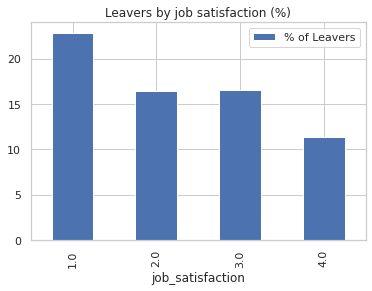

In [84]:
df_job_satisfaction = pd.DataFrame(columns = ['job_satisfaction', '% of Leavers'])
for i, satisfaction in enumerate(list(df.JobSatisfaction.unique())):
    ratio = df[(df.JobSatisfaction == satisfaction) & (df.Attrition == 'Yes')].shape[0] / df[df.JobSatisfaction == satisfaction].shape[0]
    df_job_satisfaction.loc[i] = (satisfaction, ratio * 100)
df_JS = df_job_satisfaction.groupby(by = 'job_satisfaction').sum()
df_JS.plot(kind = 'bar', title = 'Leavers by job satisfaction (%)')

### Relationship satisfaction

In [85]:
df.RelationshipSatisfaction.nunique()

4

<AxesSubplot:title={'center':'Leavers by relationship satisfaction (%)'}, xlabel='relationship_satisfaction'>

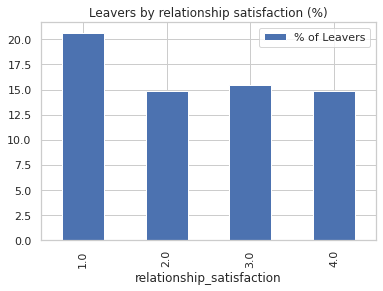

In [86]:
df_relationship = pd.DataFrame(columns = ['relationship_satisfaction', '% of Leavers'])
for i, relationship in enumerate(list(df.RelationshipSatisfaction.unique())):
    ratio = df[(df.RelationshipSatisfaction == relationship) & (df.Attrition == 'Yes')].shape[0] / df[df.RelationshipSatisfaction == relationship].shape[0]
    df_relationship.loc[i] = (relationship, ratio * 100)
df_RS = df_relationship.groupby(by = 'relationship_satisfaction').sum()
df_RS.plot(kind = 'bar', title = 'Leavers by relationship satisfaction (%)')

### Performance Rating

In [87]:
df.PerformanceRating.value_counts()

3    1244
4     226
Name: PerformanceRating, dtype: int64

<AxesSubplot:title={'center':'Leavers by performance rating (%)'}, xlabel='performance_rating'>

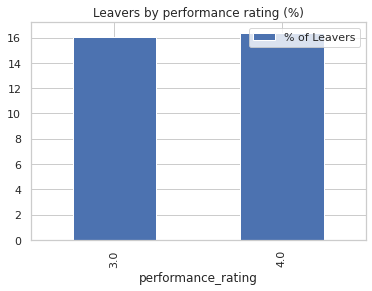

In [88]:
df_performance = pd.DataFrame(columns = ['performance_rating', '% of Leavers'])
for i, performance in enumerate(list(df.PerformanceRating.unique())):
    ratio = df[(df.PerformanceRating == performance) & (df.Attrition == 'Yes')].shape[0] / df[df.PerformanceRating == performance].shape[0]
    df_performance.loc[i] = (performance, ratio * 100)
df_PR = df_performance.groupby(by = 'performance_rating').sum()
df_PR.plot(kind = 'bar', title = 'Leavers by performance rating (%)')

### Attrition - target variable

In [89]:
df.Attrition.value_counts(normalize = 'True')

No     0.838776
Yes    0.161224
Name: Attrition, dtype: float64

<AxesSubplot:xlabel='Attrition', ylabel='count'>

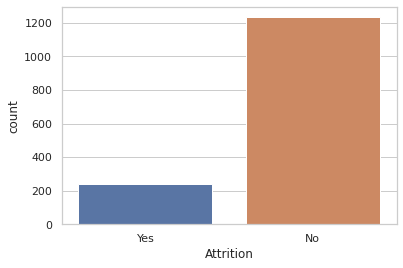

In [90]:
sns.countplot(x = df.Attrition)

### Correlation

In [91]:
df_copy = df.copy()

In [92]:
df_copy['target'] = df_copy.Attrition.apply(lambda x : 0 if x == 'No' else 1)
df_copy = df_copy.drop(['Attrition', 'EmployeeCount', 'EmployeeNumber', 'Over18', 'StandardHours'], axis = 1)
df_copy.head()

Age     BusinessTravel  DailyRate              Department  \
0   41      Travel_Rarely       1102                   Sales   
1   49  Travel_Frequently        279  Research & Development   
2   37      Travel_Rarely       1373  Research & Development   
3   33  Travel_Frequently       1392  Research & Development   
4   27      Travel_Rarely        591  Research & Development   

   DistanceFromHome  Education EducationField  EnvironmentSatisfaction  \
0                 1          2  Life Sciences                        2   
1                 8          1  Life Sciences                        3   
2                 2          2          Other                        4   
3                 3          4  Life Sciences                        4   
4                 2          1        Medical                        1   

   Gender  HourlyRate  ...  RelationshipSatisfaction  StockOptionLevel  \
0  Female          94  ...                         1                 0   
1    Male          61  ...                         4                 1   
2    Male          92  ...                         2                 0   
3  Female          56  ...                         3                 0   
4    Male          40  ...                         4                 1   

  TotalWorkingYears  TrainingTimesLastYear WorkLifeBalance  YearsAtCompany  \
0                 8                      0               1               6   
1                10                      3               3              10   
2                 7                      3               3               0   
3                 8                      3               3               8   
4                 6                      3               3               2   

   YearsInCurrentRole  YearsSinceLastPromotion YearsWithCurrManager  target  
0                   4                        0                    5       1  
1                   7                        1                    7       0  
2                   0                        0                    0       1  
3                   7                        3                    0       0  
4                   2                        2                    2       0  

[5 rows x 31 columns]

In [93]:
correlations = df_copy.corr()['target'].sort_values()
correlations

TotalWorkingYears          -0.171063
JobLevel                   -0.169105
YearsInCurrentRole         -0.160545
MonthlyIncome              -0.159840
Age                        -0.159205
YearsWithCurrManager       -0.156199
StockOptionLevel           -0.137145
YearsAtCompany             -0.134392
JobInvolvement             -0.130016
JobSatisfaction            -0.103481
EnvironmentSatisfaction    -0.103369
WorkLifeBalance            -0.063939
TrainingTimesLastYear      -0.059478
DailyRate                  -0.056652
RelationshipSatisfaction   -0.045872
YearsSinceLastPromotion    -0.033019
Education                  -0.031373
PercentSalaryHike          -0.013478
HourlyRate                 -0.006846
PerformanceRating           0.002889
MonthlyRate                 0.015170
NumCompaniesWorked          0.043494
DistanceFromHome            0.077924
target                      1.000000
Name: target, dtype: float64

In [94]:
corr = df_copy.corr()
mask = np.zeros_like(corr)

In [95]:
mask.shape

(24, 24)

In [96]:
mask[np.triu_indices_from(mask)] = True

<AxesSubplot:>

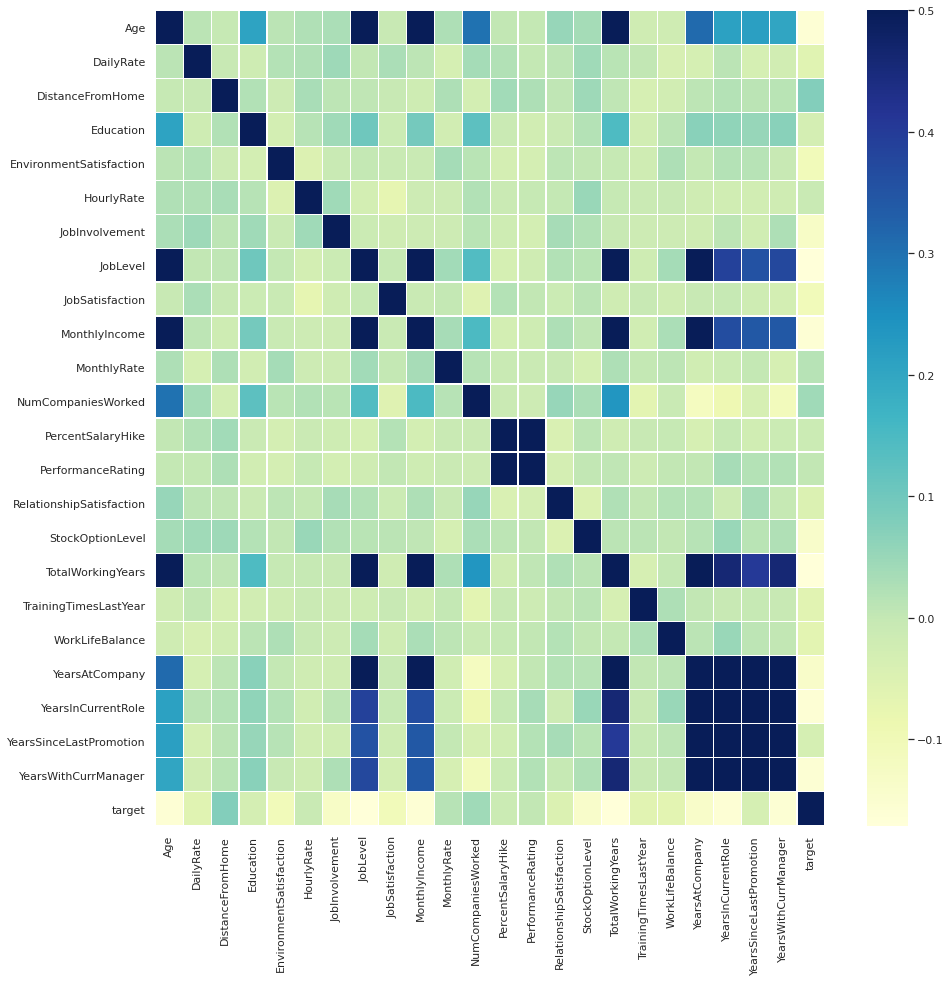

In [97]:
plt.figure(figsize = (15, 15))
sns.heatmap(corr, vmax = .5, linewidth = 0.2, cmap = 'YlGnBu')